In [167]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [170]:
CUDA = torch.cuda.is_available()

In [171]:
# #transform
# data_transforms = transforms.Compose([
#         transforms.ToTensor(),
#         lambda x: x>0.5,
#         lambda x: x.float(),
#     ])

In [172]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=bsize, shuffle=False)

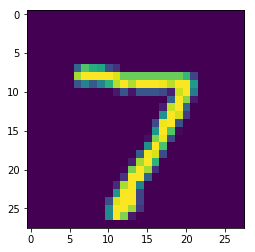

In [173]:
def get_test_img(ind=0):
    batch_idx, (data, ys) = next(enumerate(test_loader))
    test_img = Variable(data[ind:ind+1])
    return test_img

def show_test_img(ind=0):
    plt.imshow(get_test_img(ind).view(28,28).data)
    
def show_img(img):
    plt.imshow(img.view(28,28).data)
    
show_test_img()

In [174]:
# hyperparameters
N = 4
k = 2
tau = 1.

In [175]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [176]:
# conv version encoder
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x= x.view(-1,1,28,28)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [177]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(784, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         h1 = self.relu(self.fc1(x))
#         l = self.relu(self.fc2(h1))
#         return l

In [178]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [179]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [180]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [181]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)

In [182]:
class RecDecoderHead(nn.Module):
    def __init__(self):
        super(RecDecoderHead, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc1(x))
    
class RecDecoderBody(nn.Module):
    def __init__(self):
        super(RecDecoderBody, self).__init__()
        self.fc = nn.Linear(129, 128) # prev state + hidden
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderTail(nn.Module):  
    def __init__(self):
        super(RecDecoderTail, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)      
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        o = h3.view(-1,784)
        return F.sigmoid(o)    

In [183]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.E = Encoder()
        self.Ts = nn.ModuleList([Tunnel() for _ in range(N-1)])
        self.Gs = nn.ModuleList([Gate() for _ in range(N-1)])
        self.Os = nn.ModuleList([Output() for _ in range(N-1)])
        self.O0 = Output()
        self.D_head = RecDecoderHead()
        self.D_body = nn.ModuleList([RecDecoderBody() for _ in range(N-1)])
        self.Ls = nn.ModuleList([nn.Linear(_, 10) for _ in range(1,N+1)])
        self.relu = nn.ReLU()
        
    def forward(self, x):
        sofar = self.E(x)
        outputs = [self.O0(sofar)]
        
        samples = [sample(outputs[-1])]
        decoder_hidden = self.D_head(samples[-1])
        # TODO unroll this may make it faster
        for n in range(len(self.Ts)):
            sofar = self.Ts[n](sofar)*self.Gs[n](decoder_hidden)
            outputs.append(self.Os[n](sofar))
            samples.append(sample(outputs[-1]))
            
            decoder_hidden_inp = torch.cat([decoder_hidden, samples[-1]], -1)
            decoder_hidden = self.D_body[n](decoder_hidden_inp)
        
        # sliding window optimization
        
        ys = [self.Ls[0](samples[0])]
        for _ in range(len(samples)-1):
            ys.append(self.Ls[_+1](torch.cat(samples[:_+2], dim =-1)))
        
        
#         ys = [self.relu(y) for y in ys]
        ys = [F.log_softmax(y, dim = -1) for y in ys]
        return ys


In [184]:
torch.manual_seed(880)
model = Net()
if CUDA:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [185]:
torch.manual_seed(92)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
I = 3

In [186]:
# sliding window optimization

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)[I]
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        
        output = model(data)[I]
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 80 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.413694
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.286838
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.232370
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.157154
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.127024
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.983122

Test set: Average loss: 1.9580, Accuracy: 2966/10000 (30%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.912698
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.899830
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.880443
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.850075
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.693997
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.698250

Test set: Average loss: 1.5924, Accuracy: 5316/10000 (53%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.622144
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.565860
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.489902
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.343526
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.404184
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.

KeyboardInterrupt: 

In [165]:
for data, target in test_loader:
    s = Variable(data)
    break

In [166]:
E = Encoder()
E(s)

Variable containing:
 0.0542  0.0542 -0.1040  ...   0.1166  0.0321  0.0881
 0.0722  0.1088 -0.1926  ...   0.1206 -0.0525  0.1383
 0.0384  0.0524 -0.0770  ...   0.1045  0.0305  0.0386
          ...             ⋱             ...          
 0.0697  0.0397 -0.1250  ...   0.0965  0.0214  0.0888
 0.0801  0.1002 -0.1658  ...   0.0643 -0.0488  0.1180
 0.0713 -0.0030 -0.0844  ...   0.0354  0.0118  0.0241
[torch.FloatTensor of size 100x128]

In [26]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 80 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324016
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.181027
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.094387
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.961514
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.920716
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.864542

Test set: Average loss: 1.7906, Accuracy: 4189/10000 (42%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.830534
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.731514
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.663590
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.684033
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.542865
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.504835

Test set: Average loss: 1.5756, Accuracy: 4236/10000 (42%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.513642
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.471006
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.530206
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.537496
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.301418
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.


Test set: Average loss: 1.0493, Accuracy: 6617/10000 (66%)

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.915672
Train Epoch: 24 [10000/60000 (17%)]	Loss: 1.026298
Train Epoch: 24 [20000/60000 (33%)]	Loss: 0.990108
Train Epoch: 24 [30000/60000 (50%)]	Loss: 0.783080
Train Epoch: 24 [40000/60000 (67%)]	Loss: 0.900567
Train Epoch: 24 [50000/60000 (83%)]	Loss: 1.066752

Test set: Average loss: 1.0390, Accuracy: 6680/10000 (67%)

Train Epoch: 25 [0/60000 (0%)]	Loss: 1.111115
Train Epoch: 25 [10000/60000 (17%)]	Loss: 1.190912
Train Epoch: 25 [20000/60000 (33%)]	Loss: 1.070360
Train Epoch: 25 [30000/60000 (50%)]	Loss: 1.101280
Train Epoch: 25 [40000/60000 (67%)]	Loss: 0.776606
Train Epoch: 25 [50000/60000 (83%)]	Loss: 0.942170

Test set: Average loss: 1.0702, Accuracy: 6576/10000 (66%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 1.095034
Train Epoch: 26 [10000/60000 (17%)]	Loss: 0.978490
Train Epoch: 26 [20000/60000 (33%)]	Loss: 1.070515
Train Epoch: 26 [30000/60000 (50%)]	Loss: 0.966054
Train Epoch: 26 

KeyboardInterrupt: 

In [ ]:
%%time
torch.manual_seed(32)
for epoch in range(30):
    q, bits = train(epoch)

In [ ]:
%%time
torch.manual_seed(32)
for epoch in range(10):
    q, bits = train(epoch)